# LSTM Closing Price Predictor

Keras Sequential Model using LSTM layers for normalized closing price movement pridictions 

Uses window of n days to make initial prediction, then window slides forward n days incorporating prediction data into new predictions, genrating a vector of n forward predictions. 

From intial analysis this returns something that looks like a momentum unit vector.

In [3]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import util #ML4T util lib


%matplotlib notebook

In [107]:
def format_data(df,seq_len):
    """
    Slice Dataframe into training and testing sets
    
    Keyword arguments:
    df -- pandas dataframe of closing prices for stock
    seq_len -- length of the window to feed into network
    """
    
    sequence_length = seq_len + 1 
    data=df.as_matrix()
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    normalised_data = []
    for window in result:
        normalised_window = (window / window[0]) - 1
        normalised_data.append(normalised_window)
        
    result = np.array(normalised_data)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def feedforward_predict_sequence(model,data,window):
    """
    Feed-forward prediction for window size
    
    Keyword arguments:
    model -- keras LSTM model
    data -- np.array of input data
    window -- length of window to predict on
    """
    curr_frame = data
    predicted = []
    for j in xrange(window):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window-1], predicted[-1], axis=0)    
    return predicted

def predict_plot_forward(model,df,window):
    """
    Predict and Plot Forward in Time
    
    Predict window size of future price data from window size of latest available data.
    
    Plot window size prior days of input data, and rolling 50 day mean. 
    Then plot feedforward prediction sequence.
    
    Keyword arguments:
    model -- keras LSTM model
    df -- pandas dataframe of closing prices for stock
    window -- length of window to predict on
    """
    data = df[dt.date.today() - dt.timedelta(3*window):].ix[-window:].as_matrix()
    ndata = np.array((data/ data[0]) -1)
    input_data = np.reshape(ndata, (ndata.shape[0],  1)) 

    predicted =  feedforward_predict_sequence(model,input_data,window)

    un_normal = data[0]*(np.array(predicted) + np.ones(len(predicted)))
    mean= df.rolling(50).mean()[dt.date.today() - dt.timedelta(window*3):].ix[-window:].as_matrix()

    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(data, label='True Data')
    padding = [None for p in xrange(window)]
    plt.plot(padding+ list(un_normal), label='Prediction')
    plt.plot(mean, label='50day mean')
    plt.show()
    
def plot_results_multiple(predicted_data, true_data, window):
    """
    Plot multi prediction windows from testing segment
    
    Keyword arguments:
    predicted_data -- list of prediction vectors
    true_data -- list of truth vectors
    window -- length of window to predict on
    
    """
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(pd.DataFrame(true_data).rolling(50).mean().as_matrix(), label='50day mean')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * window)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

    
def predict_sequences_multiple(model, data, window):
    """
    Predict multiple sequences from testing segment
    
    Returns: List of prediction vectors
    
    Keyword arguments:
    model -- keras lstm model
    data -- testing input
    window -- length of window to predict on
    """
    prediction_seqs = []
    for i in xrange(len(data)/window):
        predicted = feedforward_predict_sequence(model, data[i*window], window )
        prediction_seqs.append(predicted)
    return prediction_seqs

## Setup DataFrame and System Parameters

In [70]:

window=50

syms = ['AAPL','MSFT','GOOG','IBM','AMD','INTC','HPQ','NVDA','KO','AXP','FB','AMZN','TSLA','AMAT',
        'EA','EBAY','STX','SYMC','TXN','V','QCOM','PYPL','ORCL','CRM','RHT']
sd = dt.datetime(2006,1,1)
ed = dt.datetime(2017,12,31)
dates = pd.date_range(sd, ed)

X_train = np.zeros((1,50,1))
y_train = np.zeros((1,1))
#df = util.get_data([sym], dates)[sym]
for sym in syms:
    df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
    #Get training and testing segments
    X, y, X_T, y_T =  format_data(df,window)
    X_train = np.append(X_train, X, axis=0)
    y_train = np.append(y_train,y, axis=0)
print X_train.shape
print y_train.shape

(58497, 50, 1)
(58497, 1)


## Build LSTM Model

In [92]:
model = Sequential()

model.add(LSTM(50, return_sequences=True,input_shape=(window,1)))
model.add(Dropout(0.2))

model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(800, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(800, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(800, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  0.0294010639191


## Train Model

In [102]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=5,
    validation_split=0.05)

Train on 55572 samples, validate on 2925 samples
Epoch 1/5
55572/55572 [==============================] - 176s - loss: 0.0027 - val_loss: 0.0019
Epoch 2/5
55572/55572 [==============================] - 177s - loss: 0.0024 - val_loss: 0.0021
Epoch 3/5
55572/55572 [==============================] - 178s - loss: 0.0022 - val_loss: 0.0018
Epoch 4/5
55572/55572 [==============================] - 176s - loss: 0.0020 - val_loss: 0.0013
Epoch 5/5
55572/55572 [==============================] - 175s - loss: 0.0020 - val_loss: 9.2408e-04


## Evaluate

In [104]:
sym='AAPL'
df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
X, y, X_test, y_test =  format_data(df,window)

In [105]:
print model.evaluate(X_test, y_test, batch_size=32, verbose=1, sample_weight=None)

283/283 [==============================] - 1s     
0.000375085837346


## Test and Predict

<IPython.core.display.Javascript object>


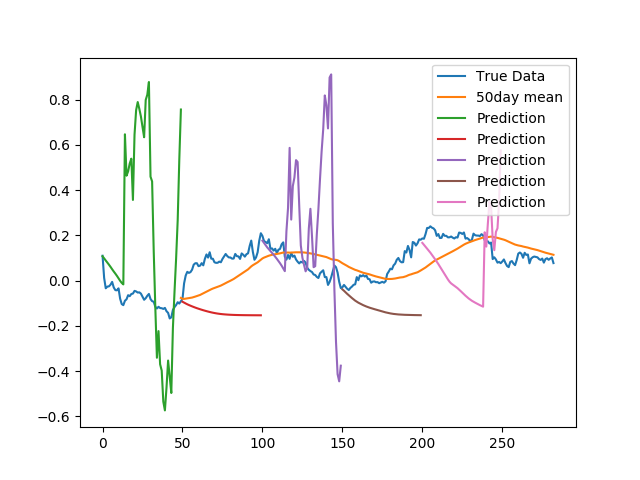

In [108]:
#Predict and plot on normalized testing data

predictions = predict_sequences_multiple(model, X_test, window)
plot_results_multiple(predictions, y_test, 50)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


<IPython.core.display.Javascript object>


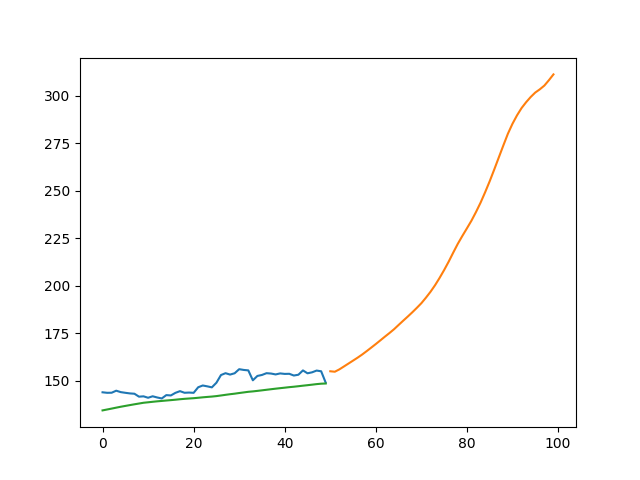

In [101]:
#Predict and plot forward in time
predict_plot_forward(model,df,window)